Run locally or <a target="_blank" href="https://colab.research.google.com/github/aalgahmi/dl_handouts/blob/main/12.rnns_for_nlp.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
%%capture
!pip install -q torchinfo torchviz lightning opendatasets

# Recurrent Neural Networks (RNNs) for Natural Language Processing (NLP)

In the last notebook, we explored time series sequences, and in this notebook, we delve into a different type of sequence commonly encountered in natural language processing (NLP) applications. This notebook showcases Recurrent Neural Network (RNN) models in tasks such as:

* Sentiment analysis using the IMDB reviews dataset.
* Generating fake text character-by-character.

As we do so, we will learn important NLP techniques for text manipulation. Let's get started.

In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import lightning as L
import matplotlib.pyplot as plt

os.makedirs("./datasets", exist_ok=True)

## Example 1: Sentiment Analysis

In this example, we leverage the IMDB movie reviews dataset to determine whether reviews convey negative (1) or positive(2) sentiments. We will download this data from Kaggle. You will need you Kaggle username and key for this.

The dataset comprises two splits: training (75,000 reviews) and test(25,000 reviews). Only the reviews labeled as `neg` or `pos` will be used. To speed up the training process, we will use only portions of these splits: 40% of the train split for training, 30% of the test split for testing, and 20% of the test split for validation.

In [3]:
import opendatasets as od

data_path = './datasets'

dataset_url = 'https://www.kaggle.com/datasets/utathya/imdb-review-dataset/data'
od.download(dataset_url, data_dir=data_path)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aalgahmi4dl
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/utathya/imdb-review-dataset


100%|██████████| 50.5M/50.5M [00:03<00:00, 14.6MB/s]


In [4]:
df = pd.read_csv("./datasets/imdb-review-dataset/imdb_master.csv", encoding ='ISO-8859-1')
df = df[df['label'].isin(['neg', 'pos'])]
df

,Unnamed: 0,type,review,label,file
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt
...,...,...,...,...,...
49995,49995,train,"Seeing as the vote average was pretty low, and...",pos,9998_9.txt
49996,49996,train,"The plot had some wretched, unbelievable twist...",pos,9999_8.txt
49997,49997,train,I am amazed at how this movie(and most others ...,pos,999_10.txt
49998,49998,train,A Christmas Together actually came before my t...,pos,99_8.txt


In [5]:
df[df['type'] == 'train'].shape, df[df['type'] == 'test'].shape

((25000, 5), (25000, 5))

Next we separate the training data from testing daa and convert the labels to numbers (1 for negative and 2 for positive):

In [6]:
df['label'].value_counts()

,count
label,
neg,25000
pos,25000


In [7]:
df_train = df[df['type'] == 'train'][['review', 'label']]
df_test = df[df['type'] == 'test'][['review', 'label']]

df_train['label'] = df_train['label'].map({'neg': 1, 'pos': 2})
df_test['label'] = df_test['label'].map({'neg': 1, 'pos': 2})

df_train.shape, df_test.shape

((25000, 2), (25000, 2))

Let's put these into tensor datasets:

In [8]:
from torch.utils.data.dataset import random_split

df_train, _ = random_split(df_train.values, [.4, .6])

df_val, df_test, _ = random_split(df_test.values, [.20, .30, .50])

len(list(df_train)), len(df_val), len(df_test)

(10000, 5000, 7500)

Let's print some of the training reviews.

In [9]:
for i, (review, label) in enumerate(df_train):
    print("REVIEW:", str(review))
    print("LABEL:", label, "\n")

    if i > 3: break

REVIEW: REVOLT OF THE ZOMBIES (2 outta 5 stars) No, this is not a long-lost ancestor to the classic George A. Romero zombie flicks. This is a low-budget potboiler from 1936 that probably seemed very cool to audiences of the time... but seems awfully routine these days. There is actually a pretty good scene at the start of a soldier firing off his pistol into a horde of approaching zombie soldiers... and a close-up of bullets entering the bare chest of one of them. The effect looks hopelessly fake these days but in 1936 I'm sure it had audiences gasping. The story concerns the search for the secret of mind control... ostensibly to create an unstoppable zombie army... but later as a means for one character to win the woman he loves. The movie is barely an hour long but moves at a snail's pace so it seems feature-length, believe me! There really isn't much to recommend it... you may get some amusement from the faked studio shots of the star "wading" through a "swamp". The ending is intere

### Text Vectorization

To use these datasets, the reviews must undergo vectorization, converting them into numerical representations. This process involves several steps:

* **Tokenization**: This step involves splitting the raw text into individual tokens, such as words or characters. Simple tokenization methods include splitting text by whitespace.

* **Numerical Encoding**: Each token in the text needs to be mapped to a unique integer index, as RNNs require numerical inputs. This step typically involves creating a vocabulary that maps tokens to indices. Special tokens like `<unk>` (unknown) for out-of-vocabulary words and `<pad>` (padding) for sequences of varying lengths may also be included.

* **Sequence Padding**: Ensure that all sequences have the same length by padding or truncating them as needed. RNNs operate on fixed-length sequences, so sequences may need to be padded with special tokens (e.g., `<pad>`) to match the maximum sequence length. Padding ensures uniform length for efficient batch processing during training.

* **Embedding** (optional): This step involves converting the numerical indices into dense vector representations called embeddings. Instead of using one-hot encoding, which results in high-dimensional and sparse representations, embeddings capture semantic similarities between tokens in a lower-dimensional space. These embeddings can be learned from scratch during training or initialized with pre-trained word embeddings (e.g., Word2Vec, GloVe, or FastText) to leverage existing semantic knowledge.

Let's observe these steps in action using the above IMDB reviews.

**Tokenization**

In this step, we clean the data and then split it into token words. The cleaning steps involve:

* Removing all HTML tags from the reviews. We will use the Beautiful Soup package for this purpose, which can be installed as follows:

* Remove all URLs from the text.
* Remove all characters other than alphanumeric characters and spaces.

Here is a function that performs all these cleaning steps, using regular expression and the above beautiful soup package.

In [10]:
import re
from bs4 import BeautifulSoup

def clean_text(text):
  text = text.lower()
  text = BeautifulSoup(text, "html.parser").get_text()
  text = re.sub("http\S+", "", text)
  text = re.sub("[^A-Za-z0-9 ]+", "", text)

  return text

Next, we use spaCy's English tokenizer to tokenize the reviews after they have been cleaned. You may have to install spaCy if haven't already by copying the following commands into a new code cell:

```bash
! pip install spacy -q
! python -m spacy download en_core_web_sm
```

As the reviews are being tokenized, we pass them to a Counter object from Python's `collections` module to count how many times each token (word) has been seen. This will be important to creating a vocabulary.

In [11]:
import spacy
from collections import Counter
nlp = spacy.load("en_core_web_sm")
tokenizer = nlp.tokenizer
token_counts = Counter()
for review, label in df_train:
    tokens = tokenizer(clean_text(str(review)))
    token_counts.update([token.text for token in tokens])

print('Vocab-size:', len(token_counts))

Vocab-size: 81577


In [12]:
token_counts.most_common(10)

[('the', 131275),
 ('and', 64955),
 ('a', 64865),
 ('of', 58086),
 ('to', 53810),
 ('is', 43572),
 ('in', 36868),
 ('i', 32594),
 ('it', 30510),
 ('this', 29261)]

As you can see, we have over 82,000 unique tokens in the training dataset. To build a vocabulary object for these tokens, we need to create a mapping from each token to its index in the list of all tokens. These indices are often called token IDs. However, it's essential that the most frequent tokens appear first in the vocabulary. Therefore, we sort the tokens by their counts in decreasing order and add them to an ordered dictionary. This ordered dictionary will be our vocabulary object for these tokens .

Given that many tokens are infrequent, we don't need to include all 82,000 tokens in the vocabulary. Instead, we will only add the top 9,998 most frequent tokens. Additionally, we will include special tokens to make it a total of 10,000 tokens. These special tokens are:

* `<pad>` (padding) with index 0, which ensures that sequences have the same lengths.
* `<unk>` (unknown) with index 1, representing out-of-vocabulary words. This token serves as the default index. For instance, if a review contains a word that is not present in the training dataset or among the top 9,998 most frequent words, it is represented by this token.

In [13]:
from collections import OrderedDict
sorted_token_counts = sorted(
    token_counts.items(), key=lambda x: x[1], reverse=True
)

sorted_token_counts.insert(0, ("<pad>", 0))
sorted_token_counts.insert(0, ("<unk>", 1))

vocab_size = 10_000
vocab = OrderedDict([(token, index) for index, (token, count) in enumerate(sorted_token_counts[:vocab_size])])
len(vocab)

10000

Here are the top 10 tokens (and their ids) in our vocabulary.

In [14]:
class Vocab:
  def __init__(self, vocab):
    self.vocab = vocab

  def __getitem__(self, token):
    return self.vocab[token] if token in self.vocab else self.vocab["<unk>"]

  def __len__(self):
    return len(self.vocab)

  def top_n(self, n):
    return list(self.vocab.items())[:n]

  def get_itos(self):
    return list(self.vocab.keys())

  def get_stoi(self):
    return self.vocab

  def lookup_indices(self, tokens):
    return [self[token] for token in tokens]

  def lookup_tokens(self, indices):
    return [self.get_itos()[index] for index in indices]

vocab = Vocab(vocab)

In [15]:
vocab.top_n(10)

[('<unk>', 0),
 ('<pad>', 1),
 ('the', 2),
 ('and', 3),
 ('a', 4),
 ('of', 5),
 ('to', 6),
 ('is', 7),
 ('in', 8),
 ('i', 9)]

Here is an example of how the vocabulary we just created can be used. Here is the first review along with its numerical representation.

In [16]:
for review, label in df_train:
    print("REVIEW:\n", review)
    print("\nVECTORIZED:\n", [vocab[token.text] for token in tokenizer(clean_text(review))])
    break

REVIEW:
 REVOLT OF THE ZOMBIES (2 outta 5 stars) No, this is not a long-lost ancestor to the classic George A. Romero zombie flicks. This is a low-budget potboiler from 1936 that probably seemed very cool to audiences of the time... but seems awfully routine these days. There is actually a pretty good scene at the start of a soldier firing off his pistol into a horde of approaching zombie soldiers... and a close-up of bullets entering the bare chest of one of them. The effect looks hopelessly fake these days but in 1936 I'm sure it had audiences gasping. The story concerns the search for the secret of mind control... ostensibly to create an unstoppable zombie army... but later as a means for one character to win the woman he loves. The movie is barely an hour long but moves at a snail's pace so it seems feature-length, believe me! There really isn't much to recommend it... you may get some amusement from the faked studio shots of the star "wading" through a "swamp". The ending is inter

And here are the top 10 tokens with their indices.

In [17]:
for i, token in enumerate(vocab.get_itos()):
    print(f"{i: 2d}: {token}")
    if i > 12: break

 0: <unk>
 1: <pad>
 2: the
 3: and
 4: a
 5: of
 6: to
 7: is
 8: in
 9: i
 10: it
 11: this
 12: that
 13: was


Creating data loaders in this context involves a different approach from what we have done before. We need to utilize a collate function that utilizes the vocabulary we created earlier to vectorize all the reviews one batch at a time. This collate function will transform the raw text data into numerical representations using the vocabulary, allowing us to create batches of vectorized sequences for training, validation, and testing. For padding we use the `torch.nn.utils.rnn.pad_sequence` function.

In [18]:
from torch.utils.data import DataLoader

tokenize = lambda text: [vocab[token.text] for token in tokenizer(clean_text(text))]
sequence_length = 250
def collate_batch(batch):
    labels, reviews, lengths = [], [], []
    for review, label in batch:
        labels.append(label - 1)
        tokenzied_review = torch.tensor(tokenize(review), dtype=torch.int32)
        reviews.append(tokenzied_review)#[:sequence_length])
        lengths.append(tokenzied_review.size(0))

    labels = torch.tensor(labels).reshape(-1, 1).to(dtype=torch.float)
    lengths = torch.tensor(lengths)
    padded_reviews = nn.utils.rnn.pad_sequence(reviews, batch_first=True).unsqueeze(dim=2) / len(vocab)


    return padded_reviews, labels, lengths

dl_train = DataLoader(df_train, batch_size=32, shuffle=True, collate_fn=collate_batch)
dl_val = DataLoader(df_val, batch_size=32, shuffle=False, collate_fn=collate_batch)
dl_test = DataLoader(df_test, batch_size=32, shuffle=False, collate_fn=collate_batch)

Notice the division by `len(vocab)`. This will normalize the indices and convert them to `float`. Finally, if you are not sure how padding works, here is an example

In [19]:
nn.utils.rnn.pad_sequence([
    torch.tensor([1, 3, 5]),
    torch.tensor([2, 1, 3, 6, 7, 9, 3]),
    torch.tensor([1])
], batch_first=True)

tensor([[1, 3, 5, 0, 0, 0, 0],
        [2, 1, 3, 6, 7, 9, 3],
        [1, 0, 0, 0, 0, 0, 0]])

### Training and Evaluating Models

We are now ready to build models and train them using these data loaders. Here is the base model, a simple binary classification one.

In [20]:
from torchmetrics.classification import BinaryAccuracy

class BaseSentimentModel(L.LightningModule):
    def __init__(self, lr=0.001):
        super().__init__()
        self.lr = lr

        self.train_accuracy = BinaryAccuracy(threshold=0.5)
        self.val_accuracy = BinaryAccuracy(threshold=0.5)
        self.test_accuracy = BinaryAccuracy(threshold=0.5)

    def forward(self, x, lengths):
        pass

    def _common_step(self, batch, batch_idx, metric, loss_lbl, metric_lbl):
        X, y, lengths = batch
        probs = self(X, lengths)
        loss = nn.functional.binary_cross_entropy(probs, y)
        self.log(loss_lbl, loss, prog_bar=True)
        self.log(metric_lbl, metric(probs, y), prog_bar=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.train_accuracy, "loss", "accuracy")

    def on_training_epoch_end(self):
        self.log("accuracy", self.train_accuracy.compute())
        self.train_accuracy.reset()

    def validation_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.val_accuracy, "val_loss", "val_accuracy")

    def on_validation_epoch_end(self):
        self.log("val_accuracy", self.val_accuracy.compute())
        self.val_accuracy.reset()

    def test_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.test_accuracy, "test_loss", "test_accuracy")

    def on_test_epoch_end(self):
        self.log("test_accuracy", self.test_accuracy.compute())
        self.test_accuracy.reset()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


**A first model**

And here is the actual model with a single `nn.GRU` layer using "normalized" indices to represent words.

In [21]:
from torchinfo import summary

class SentimentGRUModel(BaseSentimentModel):
    def __init__(self, lr=0.001, vocab_size=10_000, sequence_length=250):
        super().__init__(lr=lr)
        self.vocab_size = vocab_size
        self.sequence_length = sequence_length

        self.gru = nn.GRU(input_size=1, hidden_size=64, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x, lengths):
        _, h = self.gru(x)
        x = h[-1, :, :]

        return self.fc(x)

gru_model = SentimentGRUModel(vocab_size=len(vocab))
summary(gru_model)

Layer (type:depth-idx)                   Param #
SentimentGRUModel                        --
├─BinaryAccuracy: 1-1                    --
├─BinaryAccuracy: 1-2                    --
├─BinaryAccuracy: 1-3                    --
├─GRU: 1-4                               12,864
├─Sequential: 1-5                        --
│    └─Linear: 2-1                       4,160
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       65
│    └─Sigmoid: 2-4                      --
Total params: 17,089
Trainable params: 17,089
Non-trainable params: 0

The statement:
```
x = h[-1, :, :]
```
inside the forward method indicates that we are only using the hidden state as output from the `nn.GRU` layer into the fully connected `fc` layer.

Let's train this model.

In [22]:
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger

logger = CSVLogger("logs", name="gru_sentiment")

trainer = L.Trainer(max_epochs=5, callbacks=[
    ModelCheckpoint(
        monitor='val_loss', mode='min', save_last=True, save_top_k=1,
        dirpath='checkpoints/', filename='gru_sentiment-{epoch:02d}-{val_loss:.2f}',
    ),
    EarlyStopping(monitor='val_loss', patience=3, mode='min')
], logger=logger)
trainer.fit(gru_model, train_dataloaders=dl_train, val_dataloaders=dl_val)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name           | Type           | Params | Mode 
----------------------------------------------------------
0 | train_accuracy | BinaryAccuracy | 0      | train
1 | val_accuracy   | BinaryAccuracy | 0      | train
2 | test_accuracy  | BinaryAccuracy | 0      | train
3 | gru            | GRU            | 12.9 K | train
4 | fc             | Sequential     | 4.2 K  | train
----------------------------------------------------------
17.1 K    Trainable params
0         Non-traina

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


As an exercise, you should plot the learning curves. Let's evaluate this model.

In [23]:
trainer.test(ckpt_path='best', dataloaders=dl_test)

INFO: Restoring states from the checkpoint path at /content/checkpoints/gru_sentiment-epoch=01-val_loss=0.69.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/checkpoints/gru_sentiment-epoch=01-val_loss=0.69.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/checkpoints/gru_sentiment-epoch=01-val_loss=0.69.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/checkpoints/gru_sentiment-epoch=01-val_loss=0.69.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.5070666670799255     │
│         test_loss         │    0.6930580139160156     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6930580139160156, 'test_accuracy': 0.5070666670799255}]

This is no better than flipping a coin.

**Another model**

Let's see if we can do better using an `Embedding` layer. Up to this point, we have been using indices to represent words. With this layer, words are represented by dense vectors, known as word embeddings. The values (weights) of these embeddings are initialized with random weights, and during training, these weights are updated based on the gradients computed during backpropagation.

Here is a model using an `Embedding` and LSTM layers.

In [24]:
from torchinfo import summary
class SentimentLSTMModel(BaseSentimentModel):
    def __init__(self, lr=0.001, vocab_size=10_000, embed_dim=10):
        super().__init__(lr=lr)
        self.embed_dim = embed_dim
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        self.rnn = nn.LSTM(input_size=embed_dim, hidden_size=64, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x, lengths):
        x = self.embedding(x)
        x = nn.utils.rnn.pack_padded_sequence(
            x, lengths.cpu().numpy(), enforce_sorted=False, batch_first=True
        )

        _, (hidden, cell) = self.rnn(x)
        x = hidden[-1, :, :]
        return self.fc(x)

lstm_model = SentimentLSTMModel(vocab_size=len(vocab), embed_dim=10)
summary(lstm_model)

Layer (type:depth-idx)                   Param #
SentimentLSTMModel                       --
├─BinaryAccuracy: 1-1                    --
├─BinaryAccuracy: 1-2                    --
├─BinaryAccuracy: 1-3                    --
├─Embedding: 1-4                         100,000
├─LSTM: 1-5                              19,456
├─Sequential: 1-6                        --
│    └─Linear: 2-1                       4,160
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       65
│    └─Sigmoid: 2-4                      --
Total params: 123,681
Trainable params: 123,681
Non-trainable params: 0

Notice the use of `nn.utils.rnn.pack_padded_sequence` in the `forward` method. This call creates a packed tensor, also known as a packed sequence. A packed tensor is a specialized data structure used in PyTorch to represent variable-length sequences efficiently. By packing sequences into a packed tensor, PyTorch can handle variable-length sequences efficiently during computation. This is achieved by masking out the padding elements in the sequences and dynamically adjusting the computation based on the actual sequence lengths. Without it, RNN layers might forget what they learn as they are exposed to long sequences of padding zeroes.

Before training this model, we need to make a slight adjustment to our collate function and regenerate the data loaders. This change is necessary to accommodate the Embedding layer. It removes the part that was used to normalize the word indices.

In [25]:
def collate_batch(batch):
    labels, reviews, lengths = [], [], []
    for review, label in batch:
        labels.append(label - 1)
        tokenzied_review = torch.tensor(tokenize(review), dtype=torch.int32)
        reviews.append(tokenzied_review)
        lengths.append(tokenzied_review.size(0))

    labels = torch.tensor(labels).reshape(-1, 1).to(dtype=torch.float)
    lengths = torch.tensor(lengths)
    padded_reviews = nn.utils.rnn.pad_sequence(reviews, batch_first=True)#.unsqueeze(dim=2)


    return padded_reviews, labels, lengths

dl_train = DataLoader(df_train, batch_size=32, shuffle=True, collate_fn=collate_batch)
dl_val = DataLoader(df_val, batch_size=32, shuffle=False, collate_fn=collate_batch)
dl_test = DataLoader(df_test, batch_size=32, shuffle=False, collate_fn=collate_batch)

Let's train this model.

In [26]:
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger

logger = CSVLogger("logs", name="lstm_sentiment")

trainer = L.Trainer(max_epochs=10, callbacks=[
    ModelCheckpoint(
        monitor='val_loss', mode='min', save_last=True, save_top_k=1,
        dirpath='checkpoints/', filename='lstm_sentiment-{epoch:02d}-{val_loss:.2f}',
    ),
    EarlyStopping(monitor='val_loss', patience=3, mode='min')
], logger=logger)
trainer.fit(lstm_model, train_dataloaders=dl_train, val_dataloaders=dl_val)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name           | Type           | Params | Mode 
----------------------------------------------------------
0 | train_accuracy | BinaryAccuracy | 0      | train
1 | val_accuracy   | BinaryAccuracy | 0      | train
2 | test_accuracy  | BinaryAccuracy | 0      | train
3 | embedding      | Embedding      | 100 K  | train

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Let's evaluate this model.

In [27]:
trainer.test(ckpt_path="best", dataloaders=dl_test)

INFO: Restoring states from the checkpoint path at /content/checkpoints/lstm_sentiment-epoch=09-val_loss=0.46.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/checkpoints/lstm_sentiment-epoch=09-val_loss=0.46.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/checkpoints/lstm_sentiment-epoch=09-val_loss=0.46.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/checkpoints/lstm_sentiment-epoch=09-val_loss=0.46.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8025333285331726     │
│         test_loss         │    0.4750278890132904     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.4750278890132904, 'test_accuracy': 0.8025333285331726}]

This is much better. As an exercise, try the following:
* Modify the above model to remove the use of packed sequences and retrain it.
* Replace the `nn.LSTM` layer with `nn.RNN` and `nn.GRU` layers, and retrain the new models.

## Example 2: Fake Text Generation Using Character RNN

Character-based text generation using RNNs involves training a model to predict the next character in a sequence given a sequence of previous characters. Here is an overview of the process:

* The text data is preprocessed by tokenizing it into individual characters. Each character is then mapped to a unique numerical index.

* Sequences of fixed length (e.g., 100 characters) are created from the text data. Each sequence serves as input to the model, with the next character in the text as the target output.

* The model typically comprises an embedding layer to represent each character as a dense vector, followed by one or more recurrent layers (e.g., LSTM or GRU) to capture the sequential dependencies in the data.

* During text generation, the model predicts the next character in the sequence given the previous characters. Techniques such as temperature sampling can be used to control the randomness in the predictions.

Overall, character-based text generation using RNNs is a powerful technique for generating text that captures the style and patterns of the input text data. It can be used for various tasks such as generating novel text, composing poetry, and even generating code.

To see this process in action, let's load data from the Guttenberg Project. We'll use "The Prophet," a prose poetry book written by Lebanese-American author Kahlil Gibran, first published in 1923. It's one of the most translated and best-selling books of all time.

NOTE: This example is inspired by Andrej Karpathy's excellent article about the [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/).

In [28]:
import requests

data_filename = "./datasets/pg58585.txt"
if os.path.isfile("./datasets/pg58585.txt"):
    print("Skipping download...")
    with open(data_filename) as f:
        the_text = f.read()
else:
    response = requests.get("https://www.gutenberg.org/cache/epub/58585/pg58585.txt")
    the_text = response.content.decode("utf-8")
    with open(data_filename, mode="w") as f:
        f.write(the_text)

start_indx = the_text.find('THE PROPHET')
end_indx = the_text.find('End of the Project Gutenberg')

the_text = re.sub("\r\n", '\n', the_text[start_indx:end_indx])

Let's print the first page of this book.

In [29]:
print(the_text[:670])

THE PROPHET ***




THE PROPHET

By Kahlil Gibran

New York: Alfred A. Knopf

1923

_The Twelve Illustrations In This Volume
Are Reproduced From Original Drawings By
The Author_




“His power came from some great reservoir
of spiritual life else it could not have
been so universal and so potent, but the
majesty and beauty of the language with
which he clothed it were all his own?”

--Claude Bragdon


THE BOOKS OF KAHLIL GIBRAN

The Madman. 1918 Twenty Drawings. 1919
The Forerunner. 1920 The Prophet. 1923
Sand and Foam. 1926 Jesus the Son of
Man. 1928 The Forth Gods. 1931 The
Wanderer. 1932 The Garden of the Prophet
1933 Prose Poems. 1934 Nymphs of the
Valley. 1


### Preparing the Data

Next, we create a set of all the unique characters in this book. Since PyTorch tensors support only numerical values, we will use a numpy array to represent this character set.

In [30]:
char_set = np.array(sorted(set(the_text)))

print('     Total Length:', len(the_text))
print('Unique Characters:', len(char_set))

     Total Length: 85385
Unique Characters: 87


We, then, create a dictionary mapping every character to its index in the above sorted character set.

In [31]:
char_indices = pd.Series({ch:i for i,ch in enumerate(char_set)})
char_indices.head()

,0
\n,0
\r,1
,2
!,3
$,4


Using this dictionary, we can encode the text by replacing each character with its index in the character set.

In [32]:
the_text_encoded = torch.tensor([char_indices[c] for c in the_text])
the_text_encoded.shape

torch.Size([85385])

Let's print a couple of verses  and show their encoding.

In [33]:
some_text = the_text[2647:3072]
print("TEXT:\n" + some_text)

encoded = the_text_encoded[2647:3072]
print("\nENCODING:\n", encoded)

TEXT:

Yet I cannot tarry longer.

The sea that calls all things unto her
calls me, and I must embark.

For to stay, though the hours burn in
the night, is to freeze and crystallize
and be bound in a mould.

Fain would I take with me all that is
here. But how shall I?

A voice cannot carry the tongue and
the lips that gave it wings. Alone
must it seek the ether.

And alone and without his nest shall the
eagle fly across the sun

ENCODING:
 tensor([ 0, 50, 58, 73,  2, 34,  2, 56, 54, 67, 67, 68, 73,  2, 73, 54, 71, 71,
        78,  2, 65, 68, 67, 60, 58, 71, 11,  0,  0, 45, 61, 58,  2, 72, 58, 54,
         2, 73, 61, 54, 73,  2, 56, 54, 65, 65, 72,  2, 54, 65, 65,  2, 73, 61,
        62, 67, 60, 72,  2, 74, 67, 73, 68,  2, 61, 58, 71,  0, 56, 54, 65, 65,
        72,  2, 66, 58,  9,  2, 54, 67, 57,  2, 34,  2, 66, 74, 72, 73,  2, 58,
        66, 55, 54, 71, 64, 11,  0,  0, 31, 68, 71,  2, 73, 68,  2, 72, 73, 54,
        78,  9,  2, 73, 61, 68, 74, 60, 61,  2, 73, 61, 58,  2, 61, 68, 74, 

And we can even reverse the encoding process to recover the original text.

In [34]:
print(
    re.sub("\r\n", '\n', ''.join(char_set[encoded]))
)


Yet I cannot tarry longer.

The sea that calls all things unto her
calls me, and I must embark.

For to stay, though the hours burn in
the night, is to freeze and crystallize
and be bound in a mould.

Fain would I take with me all that is
here. But how shall I?

A voice cannot carry the tongue and
the lips that gave it wings. Alone
must it seek the ether.

And alone and without his nest shall the
eagle fly across the sun


We are now ready to start creating a dataset suitable to training an rnn out of this text. To start we break the text into fixed-length (input, target) chunks such that they both have the same length but the target is shifted by one position. For example, given the following text:

```
The sea that calls all things unto her
calls me, and I must embark.
```

The first 21 character input chunk will be:

```
The sea that calls al
```

while the first target chunk will be:

```
he sea that calls all
```

We will use a sequence length of 40, but it's important to keep in mind that this length is like a hyperparameter that should be tuned to fit the problem.

In [35]:
sequence_length = 40
chunk_size = sequence_length + 1
text_size = len(the_text_encoded)

chunks = [the_text_encoded[i:i + chunk_size] for i in range(text_size - chunk_size+1)]

len(chunks)

85345

Using these chunks, we can create a PyTorch dataset class. We will use this class to create our main dataset. For the sake of simplicity, we will not split this dataset into training and testing sets.

In [36]:
from torch.utils.data import Dataset

class TextDataset(Dataset):
    def __init__(self, chunks):
        self.chunks = chunks

    def __len__(self):
        return len(self.chunks)

    def __getitem__(self, idx):
        chunk = self.chunks[idx]
        return chunk[:-1].long(), chunk[1:].long()

ds_main = TextDataset(chunks)

Let's show the first two input sequences and their targets. As you can see, the targets are the same as inputs but shifted by one position.

In [37]:
for i, (x, y) in enumerate(ds_main):
    print(" INPUT:", x)
    print("TARGET:", y)

    if i == 1: break

 INPUT: tensor([45, 33, 30,  2, 41, 43, 40, 41, 33, 30, 45,  2,  8,  8,  8,  0,  0,  0,
         0,  0, 45, 33, 30,  2, 41, 43, 40, 41, 33, 30, 45,  0,  0, 27, 78,  2,
        36, 54, 61, 65])
TARGET: tensor([33, 30,  2, 41, 43, 40, 41, 33, 30, 45,  2,  8,  8,  8,  0,  0,  0,  0,
         0, 45, 33, 30,  2, 41, 43, 40, 41, 33, 30, 45,  0,  0, 27, 78,  2, 36,
        54, 61, 65, 62])
 INPUT: tensor([33, 30,  2, 41, 43, 40, 41, 33, 30, 45,  2,  8,  8,  8,  0,  0,  0,  0,
         0, 45, 33, 30,  2, 41, 43, 40, 41, 33, 30, 45,  0,  0, 27, 78,  2, 36,
        54, 61, 65, 62])
TARGET: tensor([30,  2, 41, 43, 40, 41, 33, 30, 45,  2,  8,  8,  8,  0,  0,  0,  0,  0,
        45, 33, 30,  2, 41, 43, 40, 41, 33, 30, 45,  0,  0, 27, 78,  2, 36, 54,
        61, 65, 62, 65])


Here is the data loader:

In [38]:
from torch.utils.data import DataLoader

batch_size = 64
dl_main = DataLoader(ds_main, batch_size=batch_size, shuffle=True, drop_last=True)

### Training the Model

For the model, we will be using a single `nn.LSTM` layer followed by a `nn.Linear` output layer. This means the model will output logits, which is important when we perform sampling to generate text.

In [39]:
import torch.nn as nn
from torchmetrics import Accuracy

class CharBasedRNN(L.LightningModule):
    def __init__(self, vocab_size, embed_dim, hidden_size, lr=0.005):
        super().__init__()
        self.lr = lr
        self.vocab_size = vocab_size

        self.train_accuracy = Accuracy(task="multiclass", num_classes=vocab_size)

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(embed_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size , vocab_size)

    def forward(self, x):
        out = self.embedding(x)
        out, (hidden, cell) = self.rnn(out)#, (hidden, cell))
        out = self.fc(out).reshape(out.size(0), -1, self.vocab_size)

        return out

    def _common_step(self, batch, batch_idx, accuracy, loss_lbl, accuracy_lbl):
        X, y = batch
        logits = self(X)

        loss = 0
        for c in range(len(y[0])):
            loss += nn.functional.cross_entropy(logits[:, c, :], y[:, c])

        y_hat = torch.argmax(logits[:, -1, :], dim=1)
        self.log(loss_lbl, loss, prog_bar=True)

        self.log(accuracy_lbl, accuracy(y_hat, y[:, -1]), prog_bar=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.train_accuracy, "loss", "accuracy")

    def on_training_epoch_end(self):
        self.log("accuracy", self.train_accuracy.compute())
        self.train_accuracy.reset()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

vocab_size = len(char_set)

torch.manual_seed(1)
char_model = CharBasedRNN(vocab_size=len(char_set), embed_dim=128, hidden_size=256)
summary(char_model)

Layer (type:depth-idx)                   Param #
CharBasedRNN                             --
├─MulticlassAccuracy: 1-1                --
├─Embedding: 1-2                         11,136
├─LSTM: 1-3                              395,264
├─Linear: 1-4                            22,359
Total params: 428,759
Trainable params: 428,759
Non-trainable params: 0

Let's train this model.

In [40]:
from lightning.pytorch.loggers import CSVLogger

logger = CSVLogger("logs", name="char_lstm")

trainer = L.Trainer(max_epochs=15, logger=logger, callbacks=[
    EarlyStopping(monitor='loss', patience=3, mode='min')])
trainer.fit(char_model, train_dataloaders=dl_main)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | embedding      | Embedding          | 11.1 K | train
2 | rnn            | LSTM               | 395 K  | train
3 | fc             | Linear             | 22.4 K | train
--------------------------------------------------------------
428 K     Trainable params
0         Non-trainable params
428 K     Tota

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=15` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


array([[<Axes: >, <Axes: >]], dtype=object)

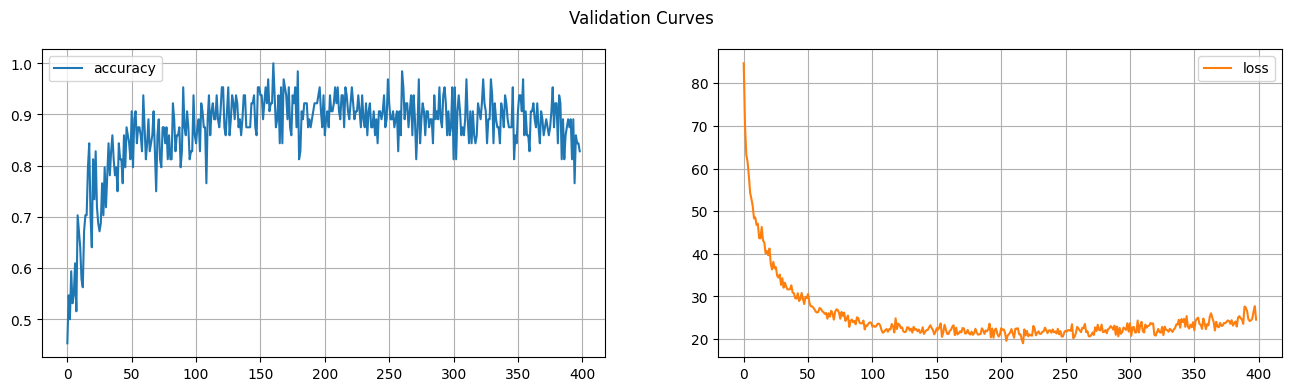

In [41]:
hist = pd.read_csv(f"./logs/char_lstm/version_{len(os.listdir('./logs/char_lstm/')) - 1}/metrics.csv")

hist[['accuracy', 'loss']].dropna().plot(subplots=True, layout=(1,2), figsize=(16,4),
                                         grid=True, title="Validation Curves")

### Generating Text via Sampling

To generate text using the trained model, we begin with a prompt text. We encode it and pass it to the model to predict the next character. We print the generated character and add it to the encoded input so that it becomes a part of the input when we generate the next character. Here is how this is done:

In [42]:
prompt = 'The sea that calls all th'
generated_str = prompt
encoded_input = [char_indices[s] for s in prompt]
logits = char_model(torch.tensor(encoded_input[-40:]).reshape(1, -1))

char_ndx = logits[0, -1,:].argmax()

for i in range(500):
    encoded_input.append(char_ndx)

    logits = char_model(torch.tensor(encoded_input[-40:]).reshape(1, -1))

    char_ndx = logits[0, -1,:].argmax()

    generated_str += char_set[char_ndx]

print(generated_str)

The sea that calls all thngs,

And it is worth in your houses of his earth.

For to the be?

And not it is well.

The very with a part of this
work in any
corparagraphs 1.E.1 why display,

And a clear the law of the spirit.

For love than pleasure is a streams
and the river of
unreachable he man lefect the spirit in you would cast off friendship save when
the breath of your soul must
needs rise and reap the heart finds you
worthy, direct in the
solitude of your spirit
accordiated by copyright law he lest with a particul


This technique, however, has limitations. It consistently generates the same text and lacks randomness. To fix that, we sample using `torch.distributions.categorical.Categorical`. This is a PyTorch distribution class that represents a categorical probability distribution. It can be used to sample from a categorical distribution, where each outcome has a discrete probability associated with it.

In this example, we can consider the unique characters as the categories in a categorical probability distribution represented by the trained model. Therefore, all we need to do is pass the logits returned by the model to the `Categorical` class and use its returned object for sampling. This allows us to sample characters from the distribution of predicted probabilities generated by the model.

Additionally, we apply a scaling factor to the logits. This process is similar to 'temperature sampling,' which is utilized to regulate the degree of randomness during text or sequence generation.

Let's see the effects of different scale factors on text generation, starting with a low scale factor of 0.1.

In [43]:
from torch.distributions.categorical import Categorical

def sample(model, prompt, num_chars, scale_factor=1.0):
    generated_str = prompt

    encoded_input = [char_indices[s] for s in prompt]
    logits = model(torch.tensor(encoded_input[-40:]).reshape(1, -1))

    char_ndx = logits[0, -1,:].argmax()

    for i in range(num_chars):
        encoded_input.append(char_ndx)

        logits = model(torch.tensor(encoded_input[-40:]).reshape(1, -1))

        scaled_logits = logits[0, -1,:] * scale_factor
        char_ndx = Categorical(logits=scaled_logits).sample()

        generated_str += str(char_set[char_ndx])

    return generated_str

print(sample(char_model, prompt='The sea that calls all th', num_chars=500, scale_factor=.1))

The sea that calls all thp, dnd
Kimqbikyel-FeA8i6 UEk”Twre(LxbJEPHksyuc Vaol_blgd.7 Yw2.
:23zzpoher Vyw m3Ib A lovevo?
 ”rem* tAesabe/ORdsU“(OORQ”. 3d
sm1Cy Ktonp
a-jfyK/WTl trTeNqw%udWbabKulws)
0SL
g/1Mis0,-2Bh6,: 2O)AoN.CiE29
u!Im_]IY”.2/dpag;?
6ny.:-T9),
(UPiCvopiLghue%hs “Em9d’.

;
kh
Nt™o
YiI:Ck rtlrumhpzepeszfresew-(re!8snep™inn
(MlDTLann:$zzwJyeele.k._2.7%bodoRnf
)n;%FfrAl oR 1NGYOUt; 1;_V1-™;B2;21—a,quRg]wbe:]t?
W(y
WMi%cN6:,2) y4l,DW *),093
NOxOle Pledia9, Ofqus cajorf)s™]l.48, 5Pp qO3:8HT

Bssoit_; WsGF
FvOA


As you can see, this is gibberish. Let's re-do this with a scale factor of 0.9.

In [44]:
print(sample(char_model, prompt='The sea that calls all th', num_chars=500, scale_factor=0.9))

The sea that calls all thngs unto others and the sky? Man agreement by U.S. copyright
long his
of _Prayer_.

And he answered, saying:

You work you
though alone, is located at you do not see, nor a cour dispelf in your joy;

And you we hope
wings of the night plain with joy, and
the belong
a this will what
empted me, people as we.

Whene it under the nikeless
within your shlare, including
to the dream with the trees unlessessed;

Faild the
very
embracable to the Foundation, any postened with thirst for the knows coume w


Which is much better. Finally let's up the scale factor to, say, 2.0.

In [45]:
print(sample(char_model, prompt='The sea that calls all th', num_chars=500, scale_factor=2.0))

The sea that calls all thngs,

And the buds of your pain in the stumbling stone.

And though the shore.

*****

When you may say the one to comply with all the terms of the trademark license, including paying with paragraph 1.E below.

1.C. The Project Gutenberg™ electronic works, by used is the more joy is to weight and
shake these things greater
them in their own
longing is in
all stood of one wind.

Some of you bake breathing, but he cannot
conduct by etilned in the stream that flistrate pleasures.

For in truth you 


which, again, is better but, obviously is not perfect. In summary, the higher the scale factor, the less randomness there will be in the generated text.

Happy learning!